In [1]:
import tensorflow as tf
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from sklearn.datasets import fetch_olivetti_faces

x_train = fetch_olivetti_faces().images

latent_dim = 100
height = 64
width = 64
channels = 1

x_train = x_train * 2 -1
x_train = np.expand_dims(x_train, axis = -1)

# Generator
generator_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.Reshape((16, 16, 128))(x)

x = layers.UpSampling2D()(x)
x = layers.Conv2D(128, 4, padding='same')(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(alpha=0.1)(x)

x = layers.UpSampling2D()(x)
x = layers.Conv2D(64, 4, padding='same')(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(alpha=0.1)(x)


x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
x = layers.BatchNormalization(momentum=0.9)(x)

generator = Model(generator_input, x)
generator.summary()




# Discriminator
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(32, 3, strides=2, padding='same')(discriminator_input)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(alpha=0.1)(x)

x = layers.Conv2D(64, 4, strides=2, padding='same')(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(alpha=0.1)(x)
#x = layers.Dropout(0.4)(x)

x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU()(x)
#x = layers.Dropout(0.4)(x)

x = layers.Conv2D(256, 4, strides=1, padding='same')(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU()(x)

x = layers.Flatten()(x)
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = Model(discriminator_input, x)
discriminator_optimizer = RMSprop(lr=0.000001)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
discriminator.summary()




# GAN
gan_input = layers.Input(shape=(latent_dim,))

# Discriminator는 학습 하지 않도록 설정 
discriminator.trainable = False
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

gan_optimizer = RMSprop(lr=0.000001)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy', metrics=['accuracy'])




# Learning
batch_size = 32

def train(epochs, print_step=100):
    history = []
    for epoch in range(epochs):
        
        # 실제 이미지 Batch 추출
        real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]
        real_label = np.ones((batch_size, 1))
        
        # 이미지 생성
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        generated_images = generator.predict(noise)
        fake_label = np.zeros((batch_size, 1))
        
        # label에 Noise 추가 
        #real_label += 0.05 * np.random.normal(0, 1, size=real_label.shape)
        #fake_label += 0.05 * np.random.normal(0, 1, size=fake_label.shape)
        
        # discriminator 학습
        d_loss_real = discriminator.train_on_batch(real_images, real_label)
        d_loss_fake = discriminator.train_on_batch(generated_images, fake_label)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Generator 학습
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # 기록
        record = (epoch, d_loss_real[0], d_loss_fake[0], d_loss[0], g_loss[0])
        history.append(record)

        if epoch % print_step == 0:
            print("Epoch : %5d [ D Loss(real) : %.5f / D Loss(Fake) : %.5f / D Loss(mean): %.5f ] G loss: %.5f" % record)
            
    return history

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 32768)             3309568   
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 128)       262272    
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 128)       0     

In [8]:
print(tf.keras.backend.int_shape(x_train))

(400, 64, 64, 1)


In [2]:
%%time
history1000 = train(10000, 500)

Epoch :     0 [ D Loss(real) : 0.45243 / D Loss(Fake) : 0.86757 / D Loss(mean): 0.66000 ] G loss: 0.69221
Epoch :   500 [ D Loss(real) : 0.08984 / D Loss(Fake) : 0.15020 / D Loss(mean): 0.12002 ] G loss: 3.65849
Epoch :  1000 [ D Loss(real) : 0.01941 / D Loss(Fake) : 0.03542 / D Loss(mean): 0.02742 ] G loss: 5.33565
Epoch :  1500 [ D Loss(real) : 0.01674 / D Loss(Fake) : 0.02038 / D Loss(mean): 0.01856 ] G loss: 5.97407
Epoch :  2000 [ D Loss(real) : 0.01520 / D Loss(Fake) : 0.03135 / D Loss(mean): 0.02328 ] G loss: 5.85951
Epoch :  2500 [ D Loss(real) : 0.01774 / D Loss(Fake) : 0.01983 / D Loss(mean): 0.01879 ] G loss: 6.91715
Epoch :  3000 [ D Loss(real) : 0.02676 / D Loss(Fake) : 0.01913 / D Loss(mean): 0.02295 ] G loss: 6.70364
Epoch :  3500 [ D Loss(real) : 0.01626 / D Loss(Fake) : 0.01485 / D Loss(mean): 0.01555 ] G loss: 7.66333
Epoch :  4000 [ D Loss(real) : 0.01598 / D Loss(Fake) : 0.01858 / D Loss(mean): 0.01728 ] G loss: 7.31751
Epoch :  4500 [ D Loss(real) : 0.01139 / D Los

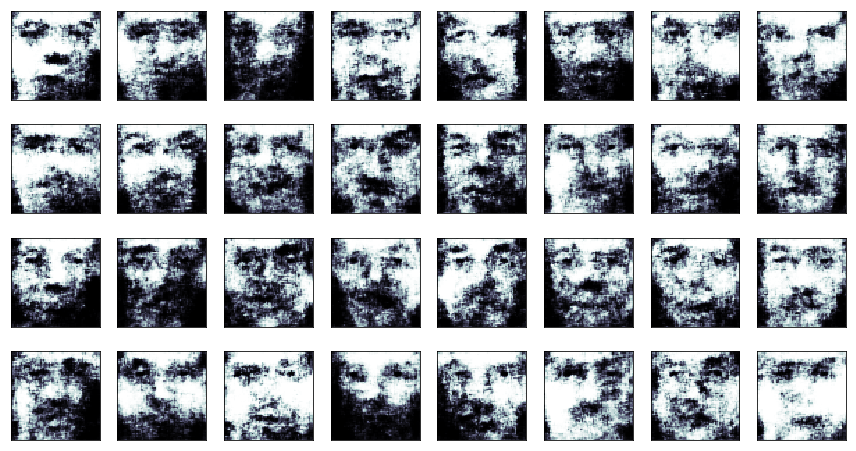

In [3]:
def show_images(generated_images, n=4, m=8, figsize=(12, 7)):
    fig = plt.figure(figsize=figsize)
    plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
    for i in range(n):
        for j in range(m):
            k = i * m + j
            ax = fig.add_subplot(n, m, i * m + j + 1)
            ax.imshow(generated_images[k][:, :, 0], cmap=plt.cm.bone)
            ax.grid(False)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
    plt.tight_layout()
    plt.show()


noise_data = np.random.normal(0, 1, size=(32, latent_dim))
show_images(0.5 * generator.predict(noise_data) + 0.5)

In [2]:
%%time
history20000 = train(19000, 2000)

Epoch :     0 / D loss: 1.032 / G loss: 0.657
Epoch :  2000 / D loss: -0.106 / G loss: 0.111
Epoch :  4000 / D loss: -0.326 / G loss: 0.006
Epoch :  6000 / D loss: 0.112 / G loss: 0.000
Epoch :  8000 / D loss: 0.430 / G loss: 0.000
Epoch : 10000 / D loss: 0.113 / G loss: 0.000
Epoch : 12000 / D loss: -0.089 / G loss: 0.000
Epoch : 14000 / D loss: -0.105 / G loss: 0.000
Epoch : 16000 / D loss: 0.075 / G loss: 0.003
Epoch : 18000 / D loss: 0.024 / G loss: 0.798
CPU times: user 24min 1s, sys: 2min 2s, total: 26min 4s
Wall time: 32min 39s


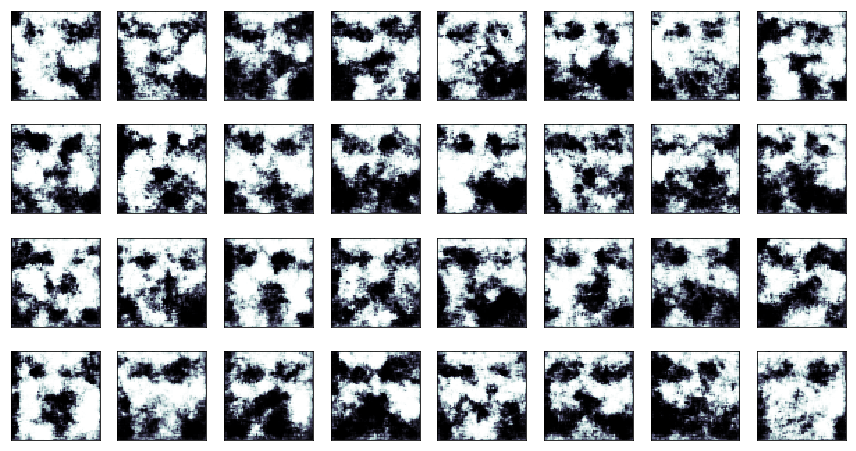

In [7]:
show_images(0.5 * generator.predict(noise_data) + 0.5)
